In [563]:
!pip install ta --quiet

DEPRECATION: Loading egg at /Users/andysstuff/anaconda3/lib/python3.12/site-packages/sympy-1.13.3-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [564]:
# Imports

# Essential
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib

# Sci-kit and Tensorflow
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# from sklearn.preprocessing import MinMaxScaler
# import requests

# Time range: past year
end_date = datetime.now()
start_date = end_date - timedelta(days=3650)

# Download data and include adjusted close
amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Check available columns
# print("Columns:", amzn_data.columns)


# Get PE ratio from metadata
amzn = yf.Ticker("AMZN")
pe_ratio = amzn.info.get('trailingPE', None)

# If PE ratio is not available, set it to NaN
if pe_ratio is None:
    pe_ratio = float('nan')  # Set it to NaN for proper DataFrame handling
else:
    pe_ratio = float(pe_ratio)  # Ensure it's a float

# Create a Series for the PE ratio with the same date index as amzn_data
pe_series = pd.Series(pe_ratio, index=amzn_data.index)

# Combine the PE ratio Series with the historical data
amzn_data['PE_Ratio'] = pe_series

# Daily Volatility (using 7-day rolling standard deviation of log returns)
amzn_data['Log_Return'] = (amzn_data['Adj Close'] / amzn_data['Adj Close'].shift(1)).apply(np.log)
amzn_data['Volatility_7d'] = amzn_data['Log_Return'].rolling(window=7).std()

# Simulated sentiment based on daily percent change
if 'Adj Close' in amzn_data.columns:
    #MA past week
    amzn_data['MA_7'] = amzn_data['Adj Close'].rolling(window=7).mean()
    #MA past month
    amzn_data['MA_30'] = amzn_data['Adj Close'].rolling(window=30).mean()
    #MA past year
    amzn_data['MA_365'] = amzn_data['Adj Close'].rolling(window=365).mean()

    amzn_data['Pct_Change'] = amzn_data['Adj Close'].pct_change()
    # amzn_data['Sentiment'] = amzn_data['Pct_Change'].apply(
    #     lambda x: 'Bullish' if x > 0 else ('Bearish' if x < 0 else 'Neutral')
    # )
else:
    print("⚠️ 'Adj Close' not found in the data. Cannot compute moving averages or sentiment.")

# # Replace with your Finnhub API key
# api_key = "d07ap6hr01qrslhn6ssgd07ap6hr01qrslhn6st0"
# # Ticker symbol for Amazon
# ticker = "AMZN"

# # Finnhub API endpoint for sentiment analysis
# url = f"https://finnhub.io/api/v1/news-sentiment?symbol={ticker}&token={api_key}"

# # Make the API request
# response = requests.get(url)

# sentiment_data = None
# # Check if the request was successful
# if response.status_code == 200:
#     sentiment_data = response.json()
#     print("Sentiment Data:", sentiment_data)
#     sentiment_score = sentiment_data["sentiment"]
#     amzn_data['Sentiment_score'] = sentiment_score
# else:
#     print("Failed to fetch sentiment data. Status code:", response.status_code)
#     amzn_data['Sentiment_score'] = float('nan')  # Set sentiment score to NaN if API fails


# Check available columns after adding metrics
# Now, modify the second index
new_columns = []

for col in amzn_data.columns:
    # Create a new tuple with the existing first index and 'AMZN' as the second index
    new_columns.append((col[0], 'AMZN'))

# Update the DataFrame's columns
amzn_data.columns = pd.MultiIndex.from_tuples(new_columns)

print("Columns:", amzn_data.columns)

# Display last few rows
print(len(amzn_data))
print(amzn_data.head())
print(amzn_data.tail())

[*********************100%***********************]  1 of 1 completed

Columns: MultiIndex([(    'Adj Close', 'AMZN'),
            (        'Close', 'AMZN'),
            (         'High', 'AMZN'),
            (          'Low', 'AMZN'),
            (         'Open', 'AMZN'),
            (       'Volume', 'AMZN'),
            (     'PE_Ratio', 'AMZN'),
            (   'Log_Return', 'AMZN'),
            ('Volatility_7d', 'AMZN'),
            (         'MA_7', 'AMZN'),
            (        'MA_30', 'AMZN'),
            (       'MA_365', 'AMZN'),
            (   'Pct_Change', 'AMZN')],
           )
2514
           Adj Close    Close       High        Low       Open    Volume  \
                AMZN     AMZN       AMZN       AMZN       AMZN      AMZN   
Date                                                                       
2015-05-04   21.1520  21.1520  21.488501  21.121000  21.240000  45408000   
2015-05-05   21.0595  21.0595  21.375500  21.051001  21.142500  57128000   
2015-05-06   20.9550  20.9550  21.136000  20.727501  21.071501  51050000   
2015-05-0

In [565]:
amzn_data.describe()
# print(len(amzn_data))

,Adj Close,Close,High,Low,Open,Volume,PE_Ratio,Log_Return,Volatility_7d,MA_7,MA_30,MA_365,Pct_Change
,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
count,2514.000000,2514.000000,2514.000000,2514.000000,2514.000000,2.514000e+03,2.514000e+03,2513.000000,2507.000000,2508.000000,2485.000000,2150.000000,2513.000000
mean,107.406705,107.406705,108.668388,106.073069,107.428630,7.515878e+07,3.334900e+01,0.000862,0.017873,107.415311,107.470070,106.608167,0.001075
std,55.233206,55.233206,55.907148,54.534817,55.253423,3.951118e+07,5.685473e-14,0.020642,0.010531,55.088667,54.605912,44.146315,0.020676
min,20.955000,20.955000,21.136000,20.727501,21.030001,1.500750e+07,3.334900e+01,-0.151398,0.001943,21.296714,21.397033,30.563562,-0.140494
25%,54.795124,54.795124,55.142500,52.981500,53.747500,4.976282e+07,3.334900e+01,-0.008874,0.010573,54.030982,54.883933,71.147458,-0.008834
50%,97.529499,97.529499,98.570999,96.162750,97.419998,6.460325e+07,3.334900e+01,0.001109,0.015383,97.382857,97.311366,115.425362,0.001110
75%,158.106125,158.106125,159.930752,156.224998,158.328247,8.926850e+07,3.334900e+01,0.011502,0.022288,157.901393,158.421949,145.959011,0.011568
max,242.059998,242.059998,242.520004,238.029999,239.020004,4.381880e+08,3.334900e+01,0.126949,0.067685,237.695714,230.223333,186.564932,0.135359


In [566]:
amzn_data.info()
# print(len(amzn_data))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2514 entries, 2015-05-04 to 2025-04-30
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   (Adj Close, AMZN)      2514 non-null   float64
 1   (Close, AMZN)          2514 non-null   float64
 2   (High, AMZN)           2514 non-null   float64
 3   (Low, AMZN)            2514 non-null   float64
 4   (Open, AMZN)           2514 non-null   float64
 5   (Volume, AMZN)         2514 non-null   int64  
 6   (PE_Ratio, AMZN)       2514 non-null   float64
 7   (Log_Return, AMZN)     2513 non-null   float64
 8   (Volatility_7d, AMZN)  2507 non-null   float64
 9   (MA_7, AMZN)           2508 non-null   float64
 10  (MA_30, AMZN)          2485 non-null   float64
 11  (MA_365, AMZN)         2150 non-null   float64
 12  (Pct_Change, AMZN)     2513 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 275.0 KB


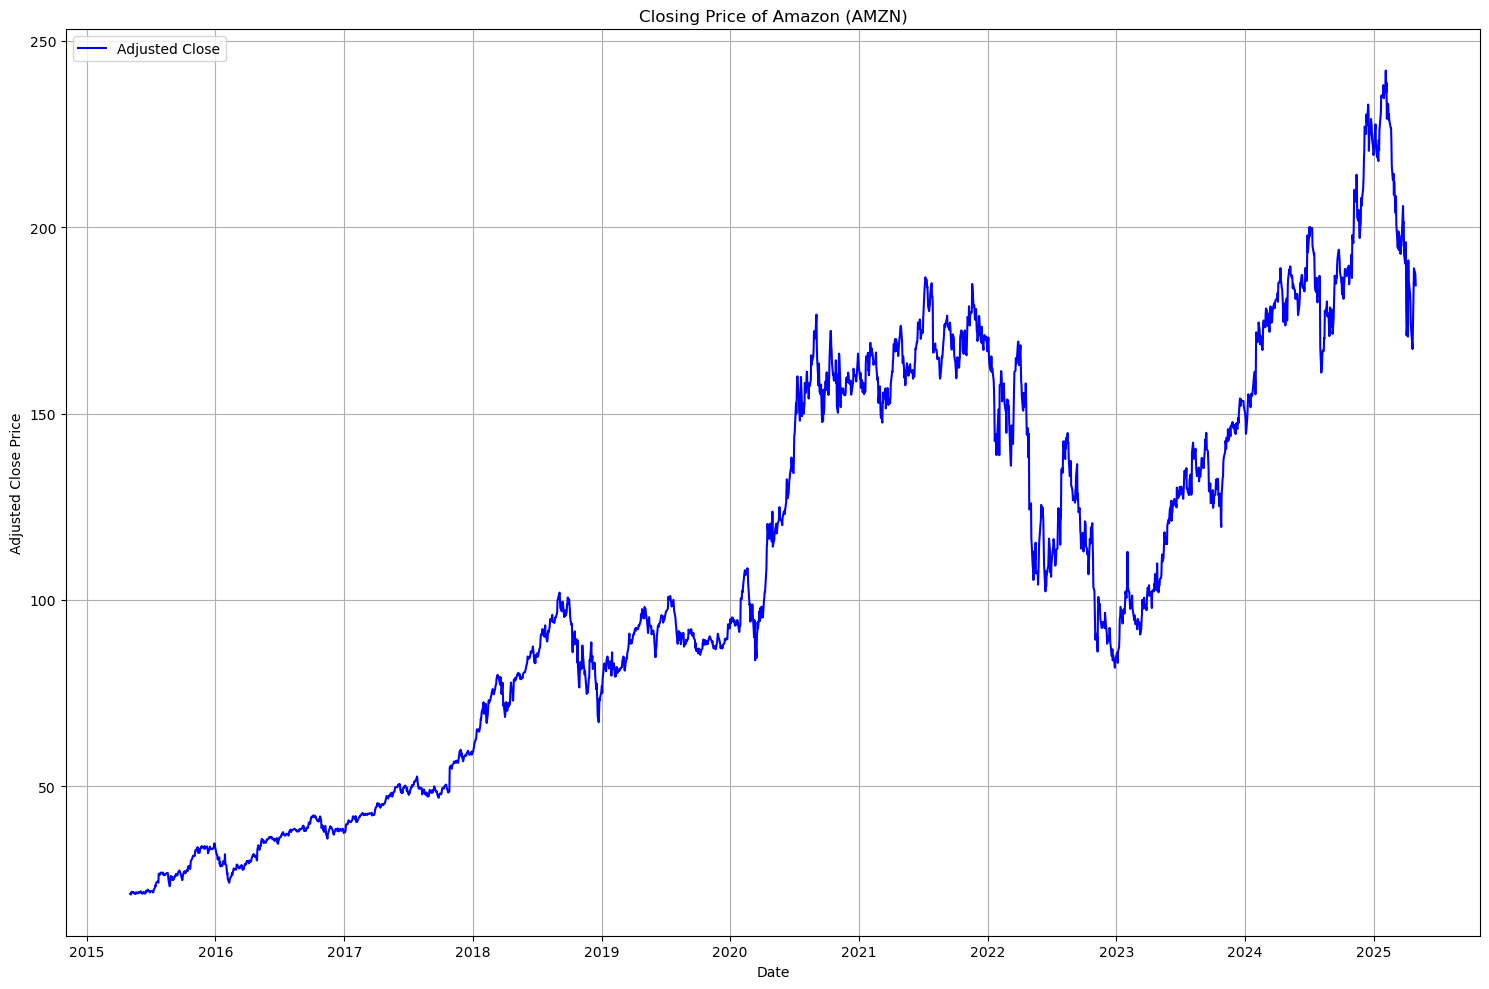

In [567]:

# Time range: past 3 years
# end_date = datetime.now()
# start_date = end_date - timedelta(days=1095)

# Download data for AMZN
# amzn_data = yf.download("AMZN", start=start_date, end=end_date, auto_adjust=False)

# Let's see a historical view of the closing price
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the adjusted closing price
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.ylabel('Adjusted Close Price')
plt.xlabel('Date')
plt.title("Closing Price of Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()


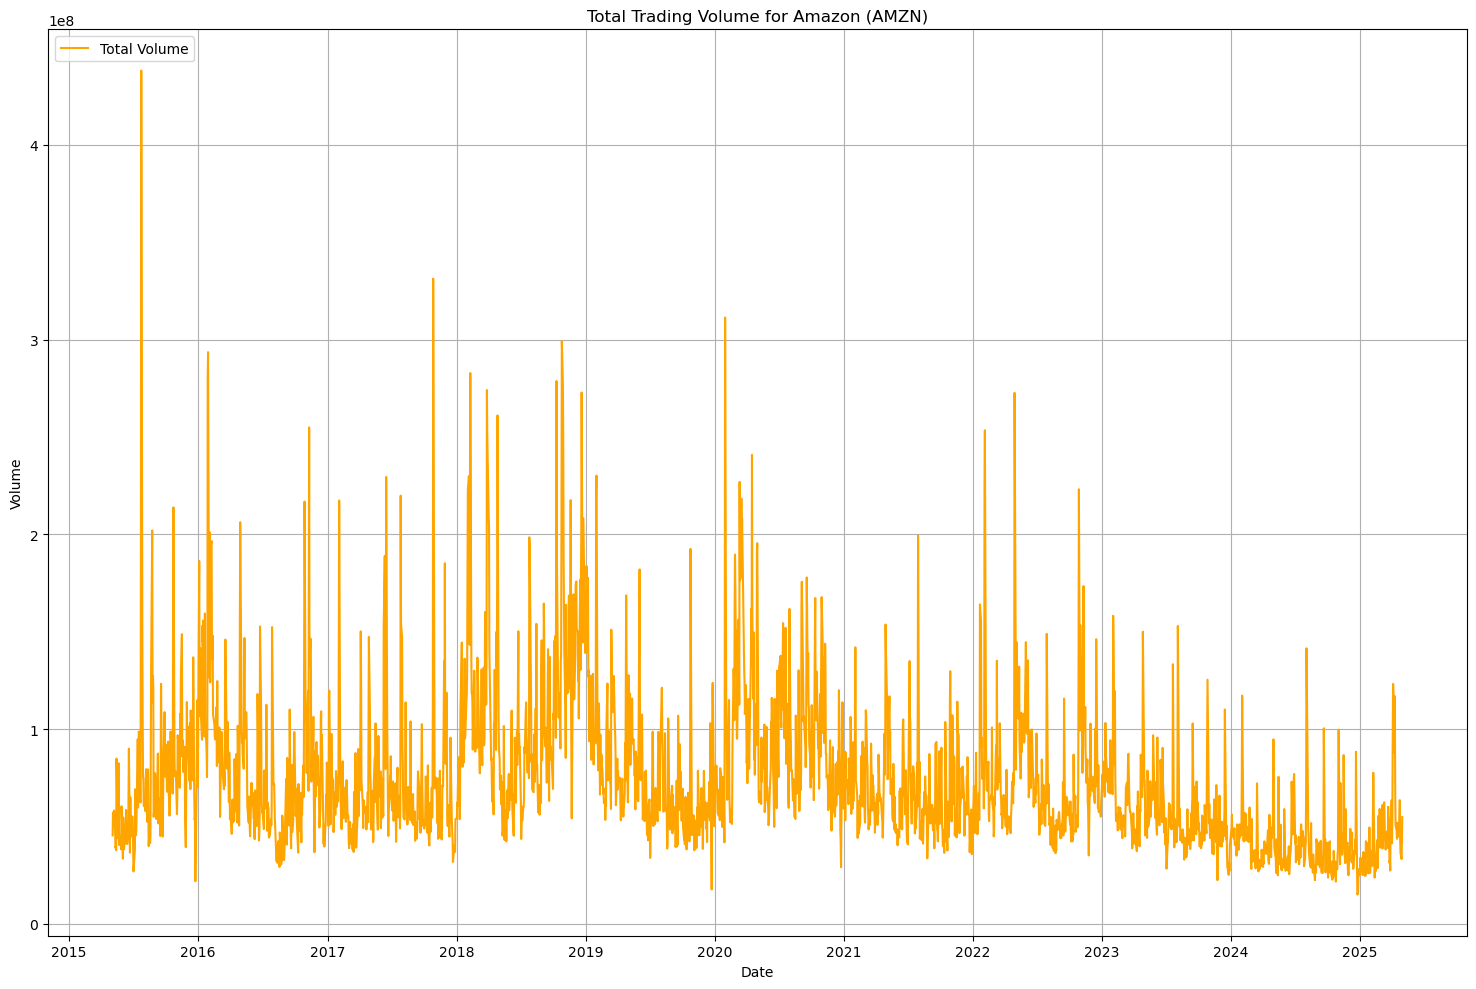

In [568]:
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Volume'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

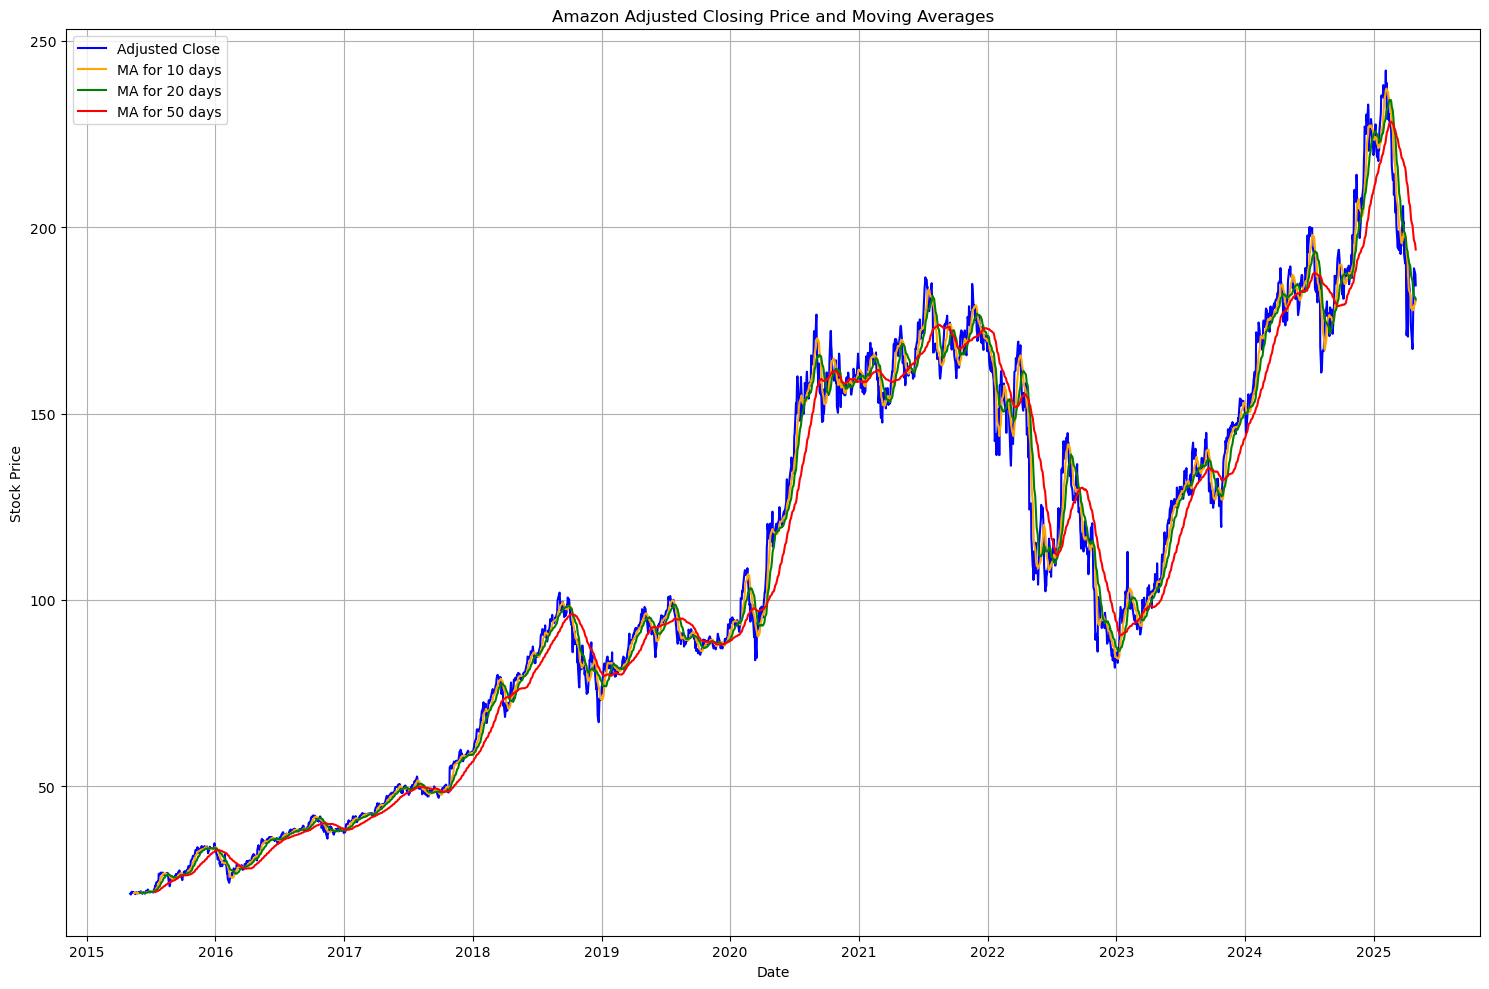

In [569]:
ma_day = [10, 20 ,50]
for ma in ma_day:
    amzn_data[f"MA for {ma} days"] = amzn_data['Adj Close'].rolling(ma).mean()

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA for 10 days'], label='MA for 10 days', color='orange')
plt.plot(amzn_data['MA for 20 days'], label='MA for 20 days', color='green')
plt.plot(amzn_data['MA for 50 days'], label='MA for 50 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


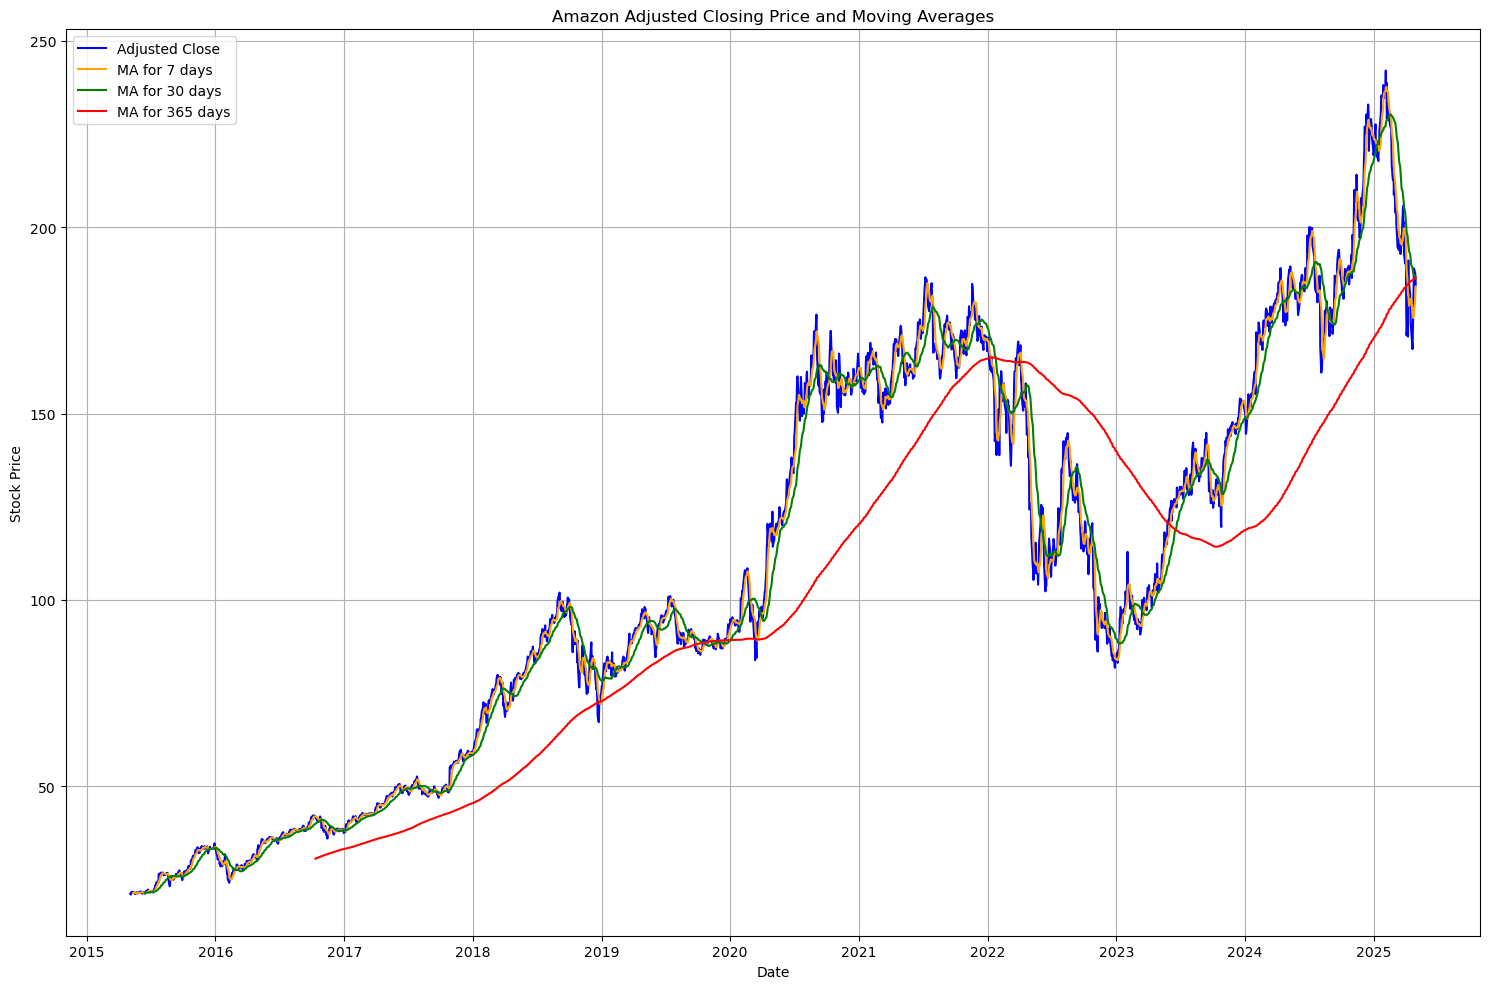

In [570]:

plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=0.2)

# Plotting adjusted close and moving averages
plt.plot(amzn_data['Adj Close'], label='Adjusted Close', color='blue')
plt.plot(amzn_data['MA_7'], label='MA for 7 days', color='orange')
plt.plot(amzn_data['MA_30'], label='MA for 30 days', color='green')
plt.plot(amzn_data['MA_365'], label='MA for 365 days', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title("Amazon Adjusted Closing Price and Moving Averages")
plt.legend()
plt.tight_layout()
plt.grid()

# Show the plot
plt.show()


2514


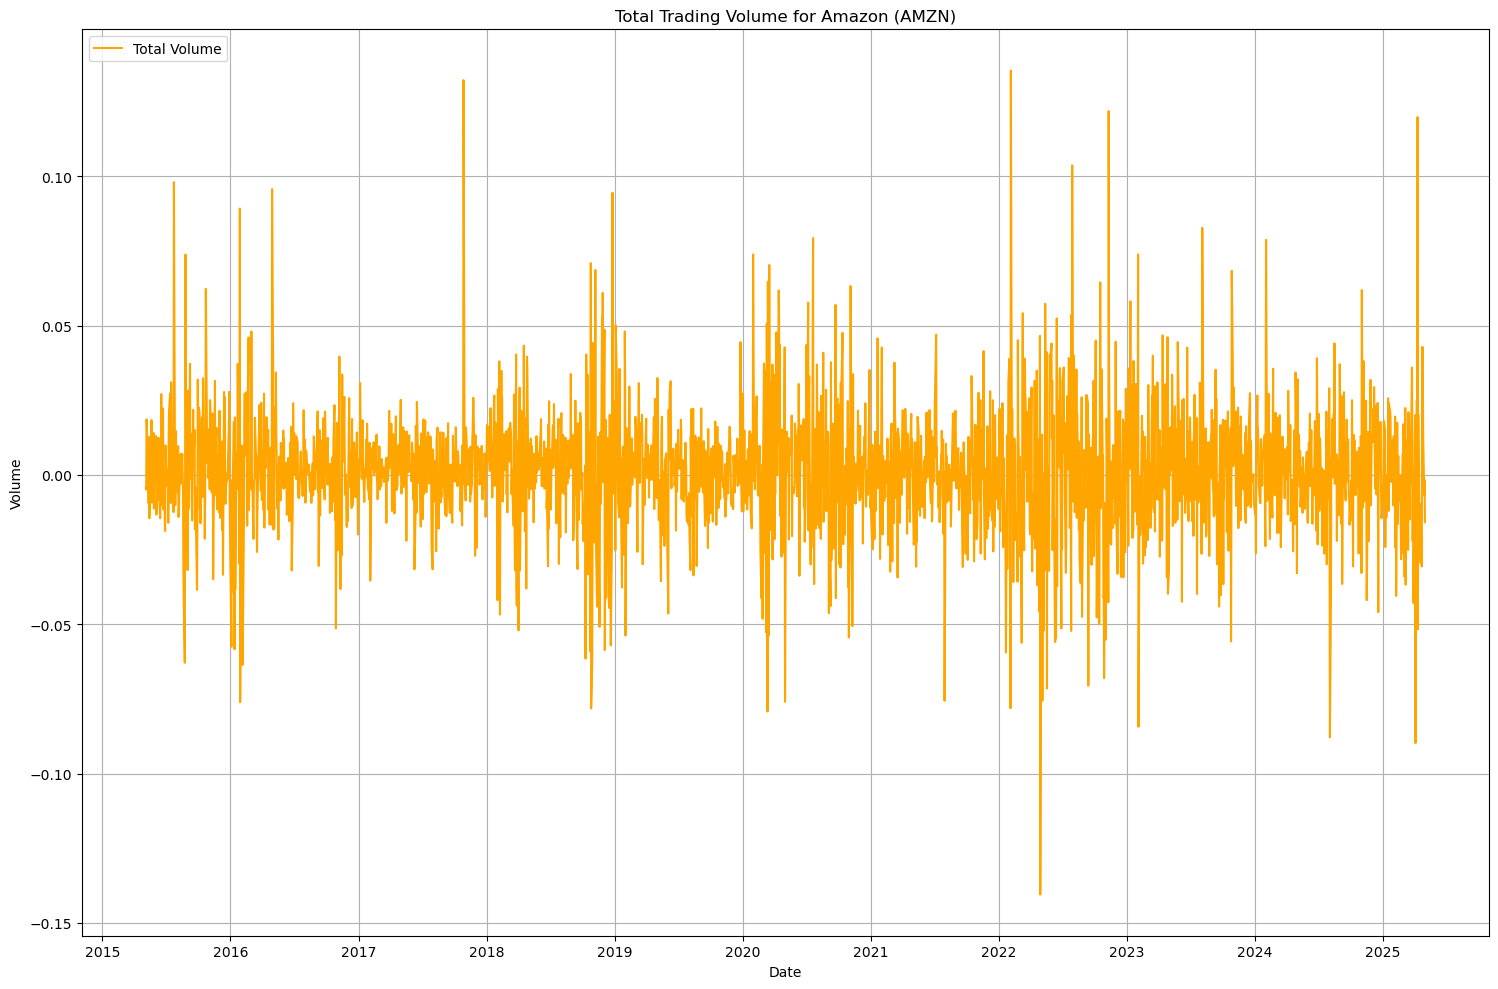

In [571]:
print(len(amzn_data))
# Now let's plot the total volume of stock being traded each day for Amazon
plt.figure(figsize=(15, 10))
plt.subplots_adjust(top=1.25, bottom=1.2)

# Plotting the trading volume for AMZN
plt.plot(amzn_data['Pct_Change'], label='Total Volume', color='orange')
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title("Total Trading Volume for Amazon (AMZN)")
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()

In [572]:
# Drop NaN values resulting from calculations

print(len(amzn_data))

# Slice original df to get most recent 3 years. This cuts off NaN values as well.
days = 1095
amzn_data = amzn_data.iloc[-(days+1):-1]

scaler = StandardScaler()
# Selecting features for training
features = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Return', 'Pct_Change', 'MA_7', 'MA_30', 'MA_365', 'Volatility_7d', 'PE_Ratio']
data = amzn_data[features]

amzn_data[features] = scaler.fit_transform(amzn_data[features])

2514


In [573]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [574]:
X = []
y = []
print(len(amzn_data))
# print(len(amzn_data))
time_steps = 30  # Lookback period
for i in range(time_steps, len(amzn_data)):
    # the line of code below adds all the features from the lookback start to the day before the current
    X.append(amzn_data[features].iloc[i-time_steps:i].values)  # Use NumPy slicing instead of iloc
    # the line below adds only the 'closing price' feature to y on the currnet day that it's trying to predict
    y.append(amzn_data['Close'].iloc[i])

X, y = np.array(X), np.array(y)
print(X.shape)
# Train-test split for LSTM
# from sklearn.model_selection import train_test_split
# the 80% to 20% training-test split ensures that the predicted closing prices are not cheating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape)

1095
(1065, 30, 13)
(681, 30, 13)


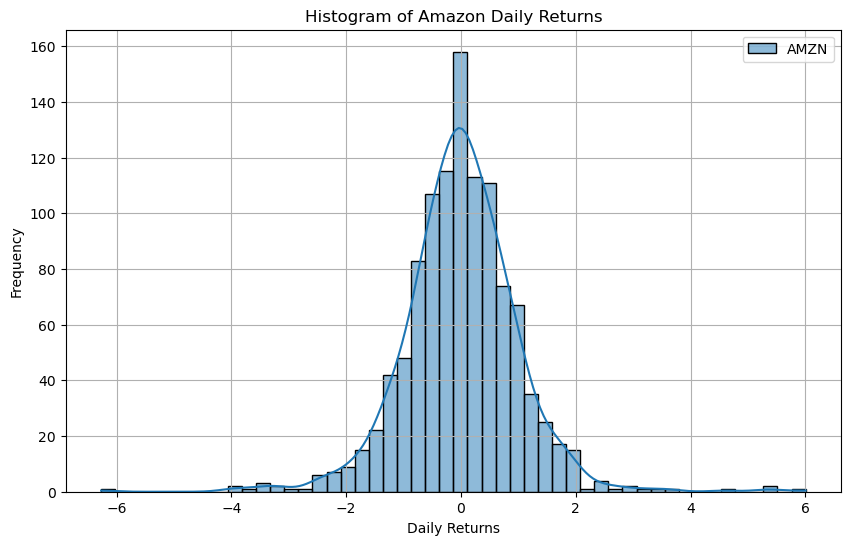

In [575]:

plt.figure(figsize=(10, 6))
sns.histplot(amzn_data['Pct_Change'].dropna(), bins=50, kde=True, color='seagreen')
plt.title('Histogram of Amazon Daily Returns')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.grid()
plt.show()


MultiIndex([(     'Adj Close', 'AMZN'),
            (         'Close', 'AMZN'),
            (          'High', 'AMZN'),
            (           'Low', 'AMZN'),
            (          'Open', 'AMZN'),
            (        'Volume', 'AMZN'),
            (      'PE_Ratio', 'AMZN'),
            (    'Log_Return', 'AMZN'),
            ( 'Volatility_7d', 'AMZN'),
            (          'MA_7', 'AMZN'),
            (         'MA_30', 'AMZN'),
            (        'MA_365', 'AMZN'),
            (    'Pct_Change', 'AMZN'),
            ('MA for 10 days',     ''),
            ('MA for 20 days',     ''),
            ('MA for 50 days',     '')],
           )
           Adj Close     Close      High       Low      Open    Volume  \
                AMZN      AMZN      AMZN      AMZN      AMZN      AMZN   
Date                                                                     
2020-12-17  0.216119  0.216119  0.199978  0.252595  0.235213  0.347903   
2020-12-18  0.166817  0.166817  0.179880  0.181458

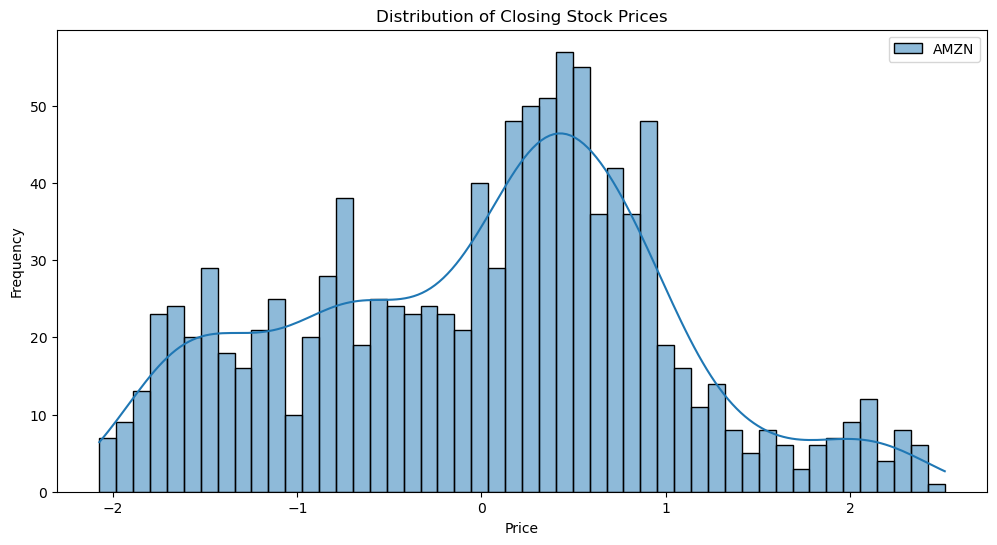

In [576]:

# Convert 'Close' column to numeric
# amzn_data['Close'] = pd.to_numeric(amzn_data['Close'], errors='coerce')
assert isinstance(amzn_data, pd.DataFrame)

print(amzn_data.columns)
# Drop rows with missing 'Close' values
# amzn_data = amzn_data.dropna(subset=['Close'])

print(amzn_data.head())
print(amzn_data.tail())
# Visualize the distribution of 'Close' prices
plt.figure(figsize=(12, 6))
sns.histplot(amzn_data['Close'], bins=50, kde=True, color='blue')
plt.title('Distribution of Closing Stock Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# # Visualize the 'Sentiment_Score'
# plt.figure(figsize=(12, 6))
# sns.histplot(amzn_data['Sentiment'], bins=50, kde=True, color='green')
# plt.title('Distribution of Sentiment Scores')
# plt.xlabel('Sentiment Score')
# plt.ylabel('Frequency')
# plt.show()


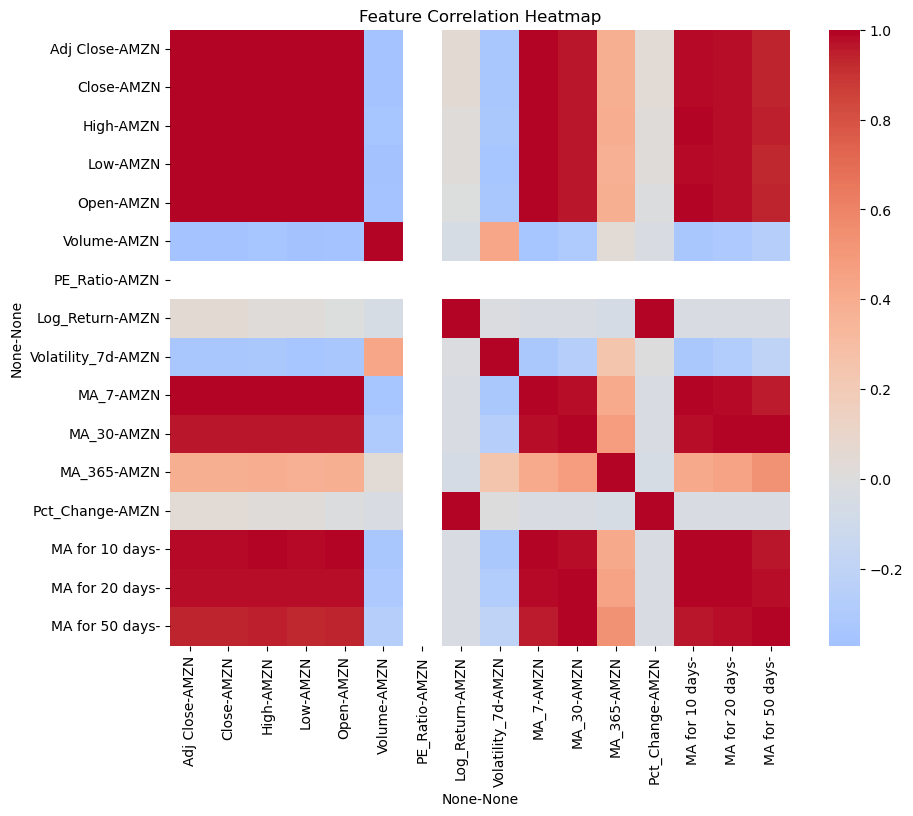

In [577]:
# Observe correlation heatmap (before PCA)

plt.figure(figsize=(10, 8))
sns.heatmap(amzn_data.corr(), annot=False, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()

In [578]:
# Explore data patterns/structures using PCA (dimensionality reduction)

# Perform PCA on origina data
pca = PCA(n_components=0.95)
amzn_data_pca = pca.fit_transform(amzn_data)

# Turn your MultiIndex into flat names
amzn_data.columns = [col[0] if isinstance(col, tuple) else col for col in amzn_data.columns]

# Calculate component loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=amzn_data.columns)

Variance explained by components: [0.98318787]
Number of principal components: 1


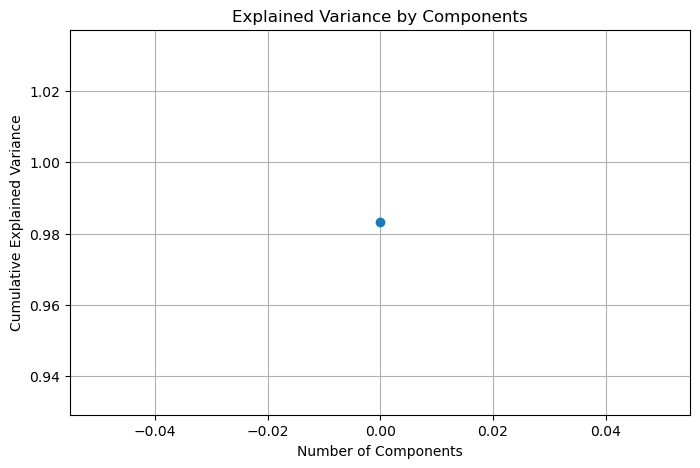

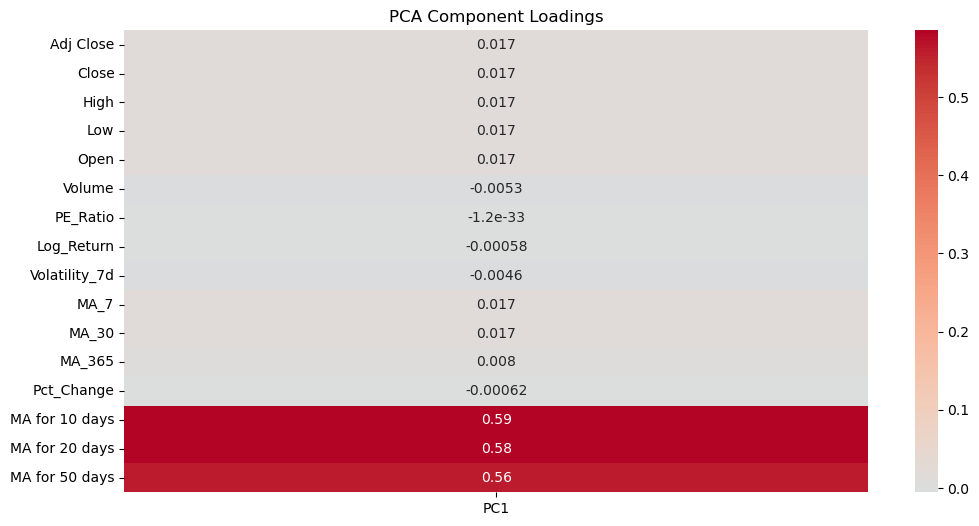

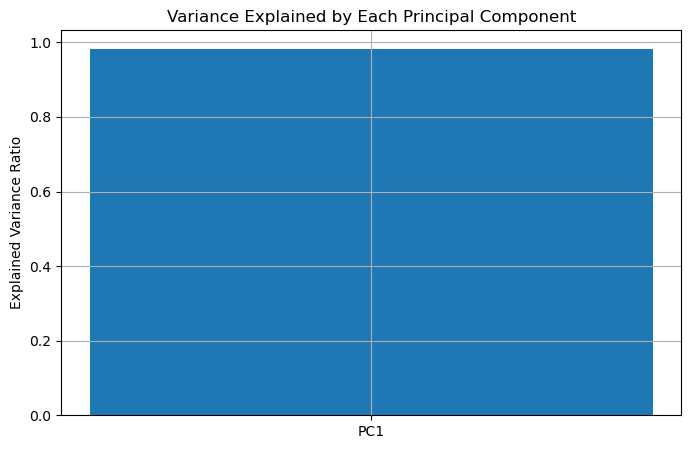

In [579]:
# Amount of variance explained by component(s)
print("Variance explained by components:", pca.explained_variance_ratio_)
# Observe: 98.3% of the variance in our data is explained by 1 principal component

# Number of principal components
print("Number of principal components:", pca.n_components_)

# Explained Variance Ratio Plot
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.show()

# Plot a heatmap of the loadings
plt.figure(figsize=(12, 6))
sns.heatmap(loadings, cmap='coolwarm', center=0, annot=True)
plt.title('PCA Component Loadings')
plt.show()

# Bar Plot of Individual Explained Variance per Component
plt.figure(figsize=(8, 5))
plt.bar(x=[f'PC{i+1}' for i in range(pca.n_components_)], height=pca.explained_variance_ratio_)
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.grid(True)
plt.show()

In [580]:
# Tuning the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.05)),
    # Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.1)),
    Dense(50),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))




Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 11.3397 - val_loss: 9.2639
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 8.7557 - val_loss: 7.2686
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.8469 - val_loss: 5.6361
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.2971 - val_loss: 4.3375
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.0673 - val_loss: 3.3120
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.1042 - val_loss: 2.5127
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.3529 - val_loss: 1.8996
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7745 - val_loss: 1.4317
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3359 - val_loss: 1.0727
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9994 - val_loss: 0.8080
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7496 - val_loss: 0.6022
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5629 - val_

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


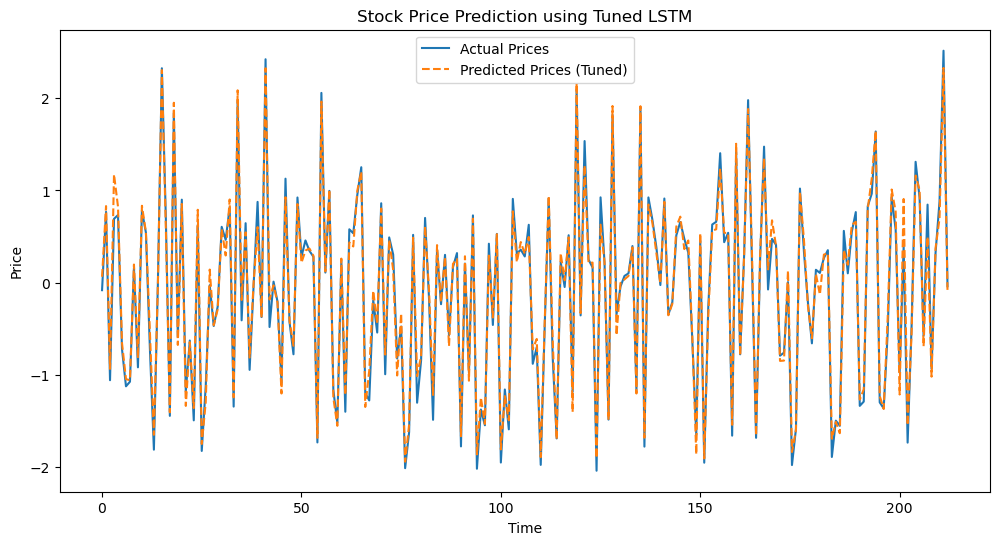

In [581]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model = model.predict(X_test)

# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()



In [582]:
# Calculate metrics
mse = mean_squared_error(y_test, lstm_predictions_model)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions_model)
r2 = r2_score(y_test, lstm_predictions_model)

#train metrics
y_train_pred = model.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

#val metrics
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

# Output the results
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R²):", r2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse)
print("R-squared (R²):", train_r2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse)
print("R-squared (R²):", val_r2)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Mean Squared Error (MSE): 0.015928366271737646
Root Mean Squared Error (RMSE): 0.12620763159071502
Mean Absolute Error (MAE): 0.09694493933765795
R-squared (R²): 0.9848539846055082
Training:

Mean Squared Error (MSE): 0.012888702750126504
R-squared (R²): 0.9872434146018051
Validation:

Mean Squared Error (MSE): 0.01547080883655781
R-squared (R²): 0.984992236685645


In [583]:
# Tuning the LSTM model
model2 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile the model
model2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9070 - val_loss: 0.0812
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1317 - val_loss: 0.0379
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0615 - val_loss: 0.0308
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0508 - val_loss: 0.0157
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0433 - val_loss: 0.0122
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0370 - val_loss: 0.0098
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0348 - val_loss: 0.0098
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0314 - val_loss: 0.0086
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0289 - val_loss: 0.0092
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0282 - val_loss: 0.0090
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0280 - val_loss: 0.0076
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0225 - val_loss: 0.0086

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


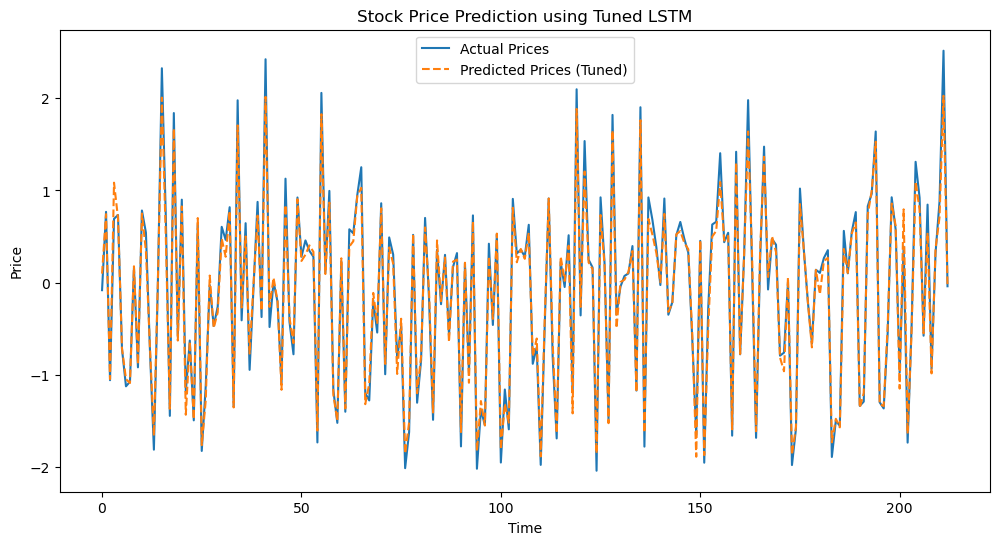

In [584]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model2 = model2.predict(X_test)

# lstm_predictions_model2 = lstm_predictions_model2[:, -1, 0]
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model2, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [585]:
# Calculate metrics
mse2 = mean_squared_error(y_test, lstm_predictions_model2)
rmse2 = np.sqrt(mse2)
mae2 = mean_absolute_error(y_test, lstm_predictions_model2)
r2_2 = r2_score(y_test, lstm_predictions_model2)

#train metrics
y_train_pred2 = model2.predict(X_train)
train_mse2 = mean_squared_error(y_train, y_train_pred2)
train_r2_2 = r2_score(y_train, y_train_pred2)

#val metrics
y_val_pred2 = model2.predict(X_val)
val_mse2 = mean_squared_error(y_val, y_val_pred2)
val_r2_2 = r2_score(y_val, y_val_pred2)

# Output the results
print("Mean Squared Error (MSE):", mse2)
print("Root Mean Squared Error (RMSE):", rmse2)
print("Mean Absolute Error (MAE):", mae2)
print("R-squared (R²):", r2_2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse2)
print("R-squared (R²):", train_r2_2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse2)
print("R-squared (R²):", val_r2_2)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 0.017291628596948817
Root Mean Squared Error (RMSE): 0.131497637229529
Mean Absolute Error (MAE): 0.09856863745561291
R-squared (R²): 0.9835576814057874
Training:

Mean Squared Error (MSE): 0.014846183297746453
R-squared (R²): 0.9853059994673942
Validation:

Mean Squared Error (MSE): 0.010626298814816509
R-squared (R²): 0.989691749202955


In [586]:
# Tuning the LSTM model
model3 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    Dropout(0.23),
    LSTM(80, return_sequences=False),
    Dropout(0.23),
    Dense(50),
    Dense(1)
])

# Compile the model
model3.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.3162 - val_loss: 0.0993
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1007 - val_loss: 0.0572
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0655 - val_loss: 0.0427
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0491 - val_loss: 0.0390
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0391 - val_loss: 0.0330
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0346 - val_loss: 0.0331
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0374 - val_loss: 0.0280
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0281 - val_loss: 0.0217
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0260 - val_loss: 0.0208
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0262 - val_loss: 0.0219
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0273 - val_loss: 0.0195
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0241 - val_l

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


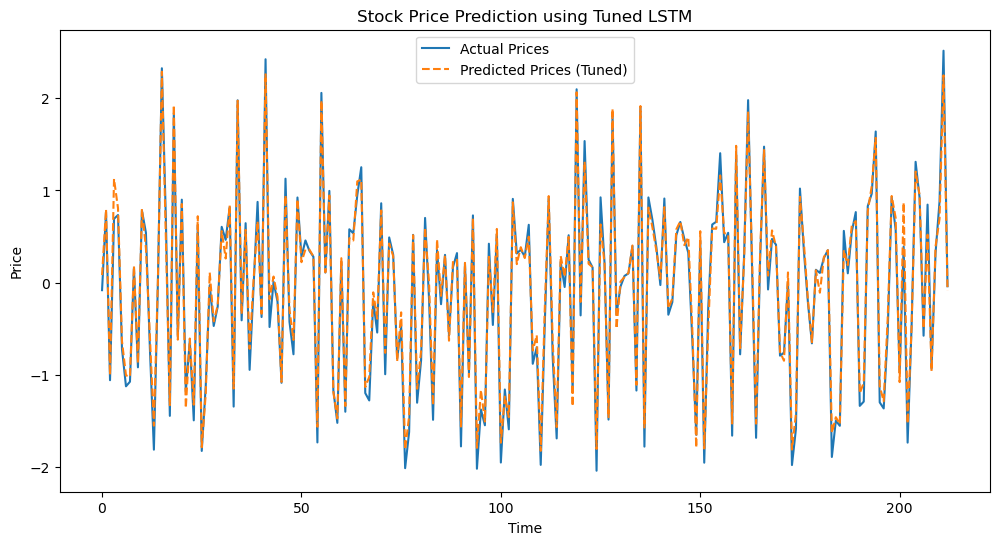

In [587]:
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model3 = model3.predict(X_test)

# lstm_predictions_model3 = lstm_predictions_model3[:, -1, 0]
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model3, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [588]:
# Calculate metrics
mse3 = mean_squared_error(y_test, lstm_predictions_model3)
rmse3 = np.sqrt(mse3)
mae3 = mean_absolute_error(y_test, lstm_predictions_model3)
r2_3 = r2_score(y_test, lstm_predictions_model3)

#train metrics
y_train_pred3 = model3.predict(X_train)
train_mse3 = mean_squared_error(y_train, y_train_pred3)
train_r2_3 = r2_score(y_train, y_train_pred3)

#val metrics
y_val_pred3 = model3.predict(X_val)
val_mse3 = mean_squared_error(y_val, y_val_pred3)
val_r2_3 = r2_score(y_val, y_val_pred3)

# Output the results
print("Mean Squared Error (MSE):", mse3)
print("Root Mean Squared Error (RMSE):", rmse3)
print("Mean Absolute Error (MAE):", mae3)
print("R-squared (R²):", r2_3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse3)
print("R-squared (R²):", train_r2_3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse3)
print("R-squared (R²):", val_r2_3)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Mean Squared Error (MSE): 0.016555183376678318
Root Mean Squared Error (RMSE): 0.12866694749110325
Mean Absolute Error (MAE): 0.10106920291335576
R-squared (R²): 0.9842579547704957
Training:

Mean Squared Error (MSE): 0.012514978859246708
R-squared (R²): 0.9876133075865206
Validation:

Mean Squared Error (MSE): 0.01453691946069065
R-squared (R²): 0.9858981744981327


In [589]:
# Tuning the LSTM model
model4 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(64, return_sequences=False),
    Dropout(0.23),
    Dense(50),
    Dense(1)
])

# Compile the model
model4.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))
# use the trained LSTM to predict the closing prices for the p
lstm_predictions_model4 = model4.predict(X_test)

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.2384 - val_loss: 0.0885
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1049 - val_loss: 0.0433
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0468 - val_loss: 0.0230
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0358 - val_loss: 0.0141
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0301 - val_loss: 0.0148
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0316 - val_loss: 0.0157
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0265 - val_loss: 0.0142
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0216 - val_loss: 0.0109
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0298 - val_loss: 0.0115
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0234 - val_loss: 0.0116
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0233 - val_loss: 0.0173
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0219 - val_l

In [590]:
# Calculate metrics
mse4 = mean_squared_error(y_test, lstm_predictions_model4)
rmse4 = np.sqrt(mse4)
mae4 = mean_absolute_error(y_test, lstm_predictions_model4)
r2_4 = r2_score(y_test, lstm_predictions_model4)

#train metrics
y_train_pred4 = model4.predict(X_train)
train_mse4 = mean_squared_error(y_train, y_train_pred4)
train_r2_4 = r2_score(y_train, y_train_pred4)

#val metrics
y_val_pred4 = model4.predict(X_val)
val_mse4 = mean_squared_error(y_val, y_val_pred4)
val_r2_4 = r2_score(y_val, y_val_pred4)

# Output the results
print("Mean Squared Error (MSE):", mse4)
print("Root Mean Squared Error (RMSE):", rmse4)
print("Mean Absolute Error (MAE):", mae4)
print("R-squared (R²):", r2_4)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse4)
print("R-squared (R²):", train_r2_4)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse4)
print("R-squared (R²):", val_r2_4)# Calculate metrics


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Squared Error (MSE): 0.015154765847332767
Root Mean Squared Error (RMSE): 0.1231046946600038
Mean Absolute Error (MAE): 0.09482143532271001
R-squared (R²): 0.9855895882284618
Training:

Mean Squared Error (MSE): 0.011234789187060118
R-squared (R²): 0.9888803745051812
Validation:

Mean Squared Error (MSE): 0.01429572207191908
R-squared (R²): 0.9861321527833642


In [591]:
# Tuning the LSTM model
model5 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_regularizer=l2(0.01)),
    # Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.02)),
    Dense(50),
    Dense(1)
])

# Compile the model
model5.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# model.fit(X_train, y_train, batch_size=1, epochs=1)
model5.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

lstm_predictions_model5 = model5.predict(X_test)


Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2.5552 - val_loss: 1.9637
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8797 - val_loss: 1.6055
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5160 - val_loss: 1.2937
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2310 - val_loss: 1.0495
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9946 - val_loss: 0.8504
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.8084 - val_loss: 0.6904
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6590 - val_loss: 0.5650
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5383 - val_loss: 0.4633
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4417 - val_loss: 0.3833
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3666 - val_loss: 0.3176
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3040 - val_loss: 0.2712
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2570 - val_l

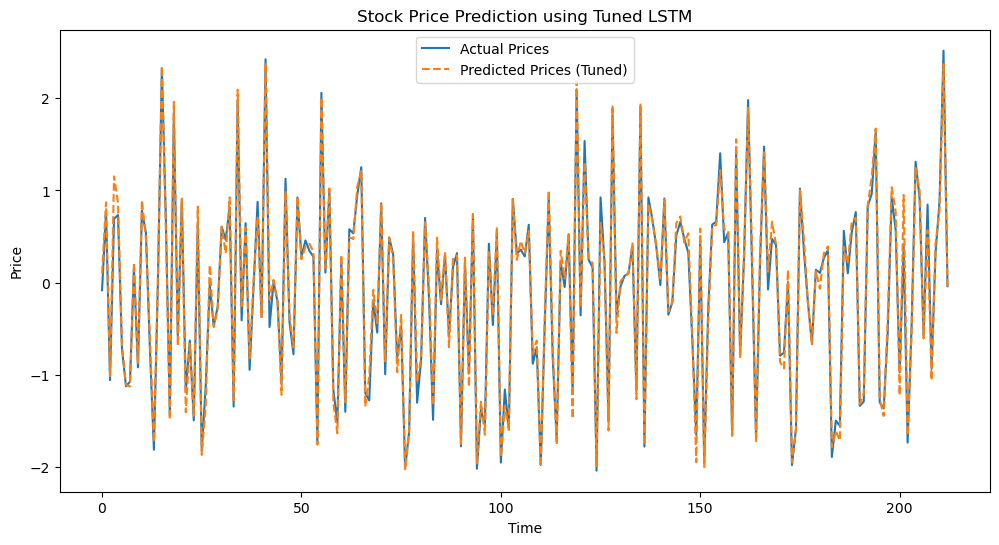

In [592]:

# lstm_predictions_model3 = lstm_predictions_model3[:, -1, 0]
# Plot the results for the tuned LSTM model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(lstm_predictions_model5, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Tuned LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [593]:
# Calculate metrics
mse5 = mean_squared_error(y_test, lstm_predictions_model5)
rmse5 = np.sqrt(mse5)
mae5 = mean_absolute_error(y_test, lstm_predictions_model5)
r2_5 = r2_score(y_test, lstm_predictions_model5)

#train metrics
y_train_pred5 = model5.predict(X_train)
train_mse5 = mean_squared_error(y_train, y_train_pred5)
train_r2_5 = r2_score(y_train, y_train_pred5)

#val metrics
y_val_pred5 = model5.predict(X_val)
val_mse5 = mean_squared_error(y_val, y_val_pred5)
val_r2_5 = r2_score(y_val, y_val_pred5)

# Output the results
print("Mean Squared Error (MSE):", mse5)
print("Root Mean Squared Error (RMSE):", rmse5)
print("Mean Absolute Error (MAE):", mae5)
print("R-squared (R²):", r2_5)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse5)
print("R-squared (R²):", train_r2_5)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse5)
print("R-squared (R²):", val_r2_5)# Calculate metrics

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Squared Error (MSE): 0.014149299885771514
Root Mean Squared Error (RMSE): 0.1189508296977012
Mean Absolute Error (MAE): 0.08988078917278595
R-squared (R²): 0.9865456688881252
Training:

Mean Squared Error (MSE): 0.011004328204265232
R-squared (R²): 0.989108473117196
Validation:

Mean Squared Error (MSE): 0.012982401602325276
R-squared (R²): 0.987406165213599


In [594]:
#NEURAL NETWORKS
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten to (num_samples, 390)
X_test = X_test.reshape(X_test.shape[0], -1)     # Flatten to (num_samples, 390)
X_val = X_val.reshape(X_val.shape[0], -1)     

print(X_train.shape)
print(X_test.shape)
# Creating the Neural Network Model
NNmodel = Sequential()
# Input layer and Hidden layer
NNmodel.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu'))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel.compile(loss='mean_squared_error', optimizer='adam')

NNmodel.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


(681, 390)
(213, 390)
Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9286 - val_loss: 0.2773
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2178 - val_loss: 0.2151
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1713 - val_loss: 0.1687
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1077 - val_loss: 0.1413
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0821 - val_loss: 0.1279
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0668 - val_loss: 0.1115
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0489 - val_loss: 0.1039
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0427 - val_loss: 0.0973
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0385 - val_loss: 0.0918
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0303 - val_loss: 0.0907
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0290 - val_loss: 0.0883
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0240 - val_loss: 0.0837


In [595]:
NN_predictions_model = NNmodel.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


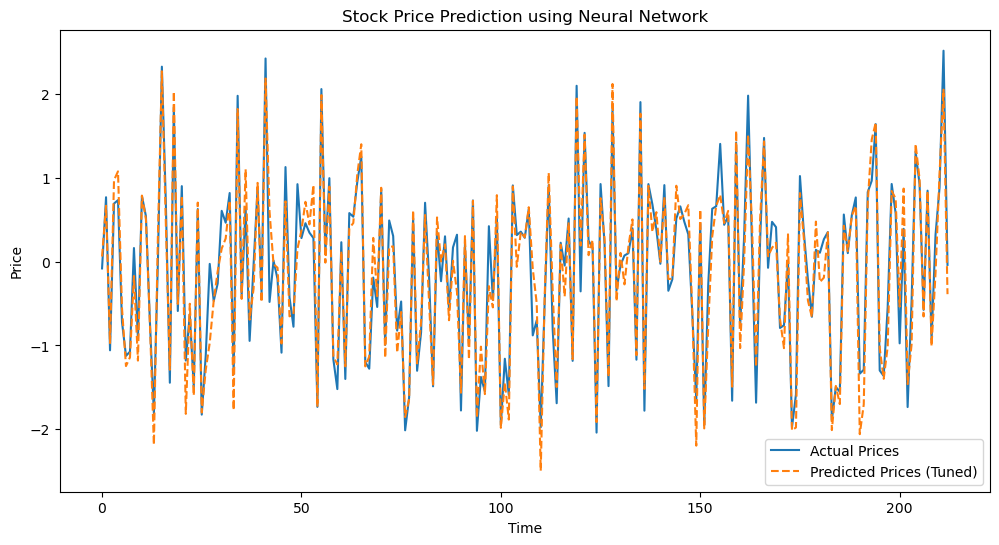

In [596]:

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [597]:
# Calculate metrics
mse_nn = mean_squared_error(y_test, NN_predictions_model)
rmse_nn = np.sqrt(mse_nn)
mae_nn = mean_absolute_error(y_test, NN_predictions_model)
r2_nn = r2_score(y_test, NN_predictions_model)

#train metrics
y_train_pred_nn = NNmodel.predict(X_train)
train_mse_nn = mean_squared_error(y_train, y_train_pred_nn)
train_r2_nn = r2_score(y_train, y_train_pred_nn)

#val metrics
y_val_pred_nn = NNmodel.predict(X_val)
val_mse_nn = mean_squared_error(y_val, y_val_pred_nn)
val_r2_nn = r2_score(y_val, y_val_pred_nn)

# Output the results
print("Mean Squared Error (MSE):", mse_nn)
print("Root Mean Squared Error (RMSE):", rmse_nn)
print("Mean Absolute Error (MAE):", mae_nn)
print("R-squared (R²):", r2_nn)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn)
print("R-squared (R²):", train_r2_nn)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn)
print("R-squared (R²):", val_r2_nn)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.07701035188784909
Root Mean Squared Error (RMSE): 0.27750739069049873
Mean Absolute Error (MAE): 0.20544041666116264
R-squared (R²): 0.92677215256544
Training:

Mean Squared Error (MSE): 0.0034639948149948366
R-squared (R²): 0.9965715133219321
Validation:

Mean Squared Error (MSE): 0.06318643402445563
R-squared (R²): 0.9387047531557421


In [598]:
# Creating the Neural Network Model
NNmodel2 = Sequential()
# Input layer and Hidden layer
# print(X.shape[2])
NNmodel2.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel2.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel2.compile(loss='mean_squared_error', optimizer='adam')

NNmodel2.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))


Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8682 - val_loss: 5.7748
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.4820 - val_loss: 5.0341
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.8256 - val_loss: 4.4292
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2773 - val_loss: 3.9605
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8250 - val_loss: 3.5370
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4186 - val_loss: 3.1538
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0403 - val_loss: 2.8133
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7175 - val_loss: 2.5145
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4309 - val_loss: 2.2512
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1780 - val_loss: 2.0192
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9532 - val_loss: 1.8143
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7559 - val_loss: 1.6326


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


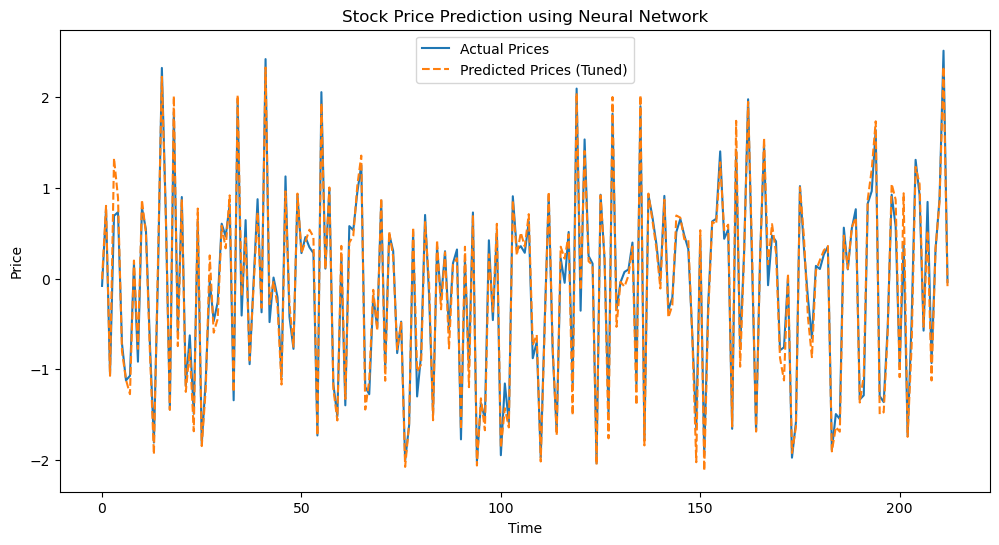

In [599]:
NN_predictions_model2 = NNmodel2.predict(X_test)

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model2, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [600]:

# Calculate metrics
mse_nn2 = mean_squared_error(y_test, NN_predictions_model2)
rmse_nn2 = np.sqrt(mse_nn)
mae_nn2 = mean_absolute_error(y_test, NN_predictions_model2)
r2_nn2 = r2_score(y_test, NN_predictions_model2)

#train metrics
y_train_pred_nn2 = NNmodel2.predict(X_train)
# print(y_train_pred_nn2)
train_mse_nn2 = mean_squared_error(y_train, y_train_pred_nn2)
train_r2_nn2 = r2_score(y_train, y_train_pred_nn2)

#val metrics
y_val_pred_nn2 = NNmodel2.predict(X_val)
val_mse_nn2 = mean_squared_error(y_val, y_val_pred_nn2)
val_r2_nn2 = r2_score(y_val, y_val_pred_nn2)

# Output the results
print("Mean Squared Error (MSE):", mse_nn2)
print("Root Mean Squared Error (RMSE):", rmse_nn2)
print("Mean Absolute Error (MAE):", mae_nn2)
print("R-squared (R²):", r2_nn2)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn2)
print("R-squared (R²):", train_r2_nn2)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn2)
print("R-squared (R²):", val_r2_nn2)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Mean Squared Error (MSE): 0.019561789465271998
Root Mean Squared Error (RMSE): 0.27750739069049873
Mean Absolute Error (MAE): 0.10532537054557259
R-squared (R²): 0.9813990236455998
Training:

Mean Squared Error (MSE): 0.01380551801865266
R-squared (R²): 0.9863359972694279
Validation:

Mean Squared Error (MSE): 0.019591432131114812
R-squared (R²): 0.9809949447686124


In [601]:
NNmodel3 = Sequential()
# Input layer and Hidden layer
NNmodel3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel3.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))

NNmodel3.add(Dense(1))  # No activation function for regression output
# Compile/build the model

NNmodel3.compile(loss='mean_squared_error', optimizer='adam')
# optimizer = Adam()
# print(optimizer.learning_rate.numpy())  # Output: 0.001


NNmodel3.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.0179 - val_loss: 7.8674
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.6188 - val_loss: 6.8091
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.5545 - val_loss: 5.8528
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6323 - val_loss: 5.0136
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8196 - val_loss: 4.2906
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1275 - val_loss: 3.6753
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5420 - val_loss: 3.1575
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.0454 - val_loss: 2.7232
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6299 - val_loss: 2.3573
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2771 - val_loss: 2.0482
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9809 - val_loss: 1.7862
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7302 - val_loss: 1.5654


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


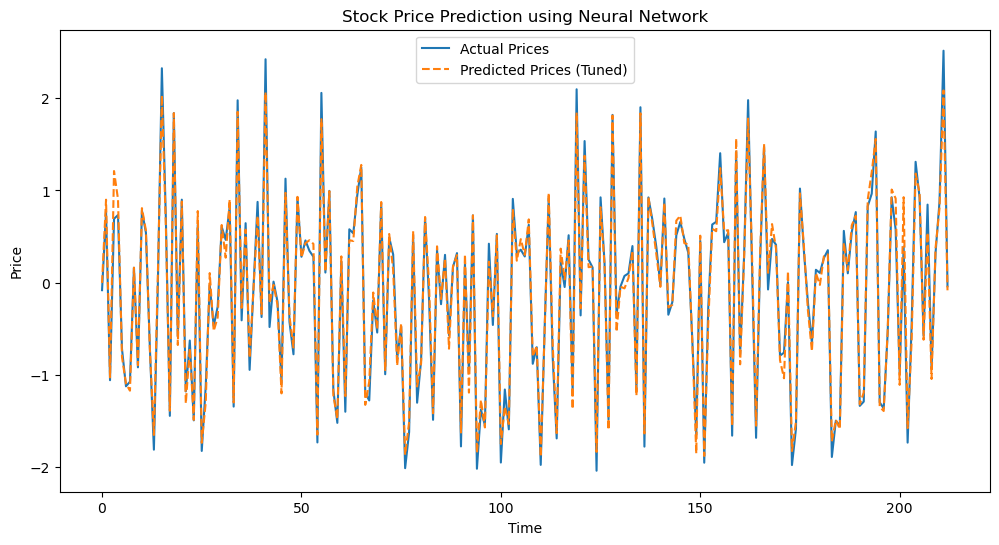

In [602]:
NN_predictions_model3 = NNmodel3.predict(X_test)

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model3, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [603]:
# Calculate metrics
mse_nn3 = mean_squared_error(y_test, NN_predictions_model3)
rmse_nn3 = np.sqrt(mse_nn3)
mae_nn3 = mean_absolute_error(y_test, NN_predictions_model3)
r2_nn3 = r2_score(y_test, NN_predictions_model3)

#train metrics
y_train_pred_nn3 = NNmodel3.predict(X_train)
train_mse_nn3 = mean_squared_error(y_train, y_train_pred_nn3)
train_r2_nn3 = r2_score(y_train, y_train_pred_nn3)

#val metrics
y_val_pred_nn3 = NNmodel3.predict(X_val)
val_mse_nn3 = mean_squared_error(y_val, y_val_pred_nn3)
val_r2_nn3 = r2_score(y_val, y_val_pred_nn3)

# Output the results
print("Mean Squared Error (MSE):", mse_nn3)
print("Root Mean Squared Error (RMSE):", rmse_nn3)
print("Mean Absolute Error (MAE):", mae_nn3)
print("R-squared (R²):", r2_nn3)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn3)
print("R-squared (R²):", train_r2_nn3)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn3)
print("R-squared (R²):", val_r2_nn3)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.016447620407668607
Root Mean Squared Error (RMSE): 0.12824827643157083
Mean Absolute Error (MAE): 0.0970649592828133
R-squared (R²): 0.9843602345873146
Training:

Mean Squared Error (MSE): 0.012893798994897872
R-squared (R²): 0.9872383705967647
Validation:

Mean Squared Error (MSE): 0.013180599781845641
R-squared (R²): 0.9872138991595742


In [604]:
NNmodel4 = Sequential()
# Input layer and Hidden layer
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))  # Activation function can be ReLU
# input layer takes into account the features of each sample during each of the time_steps
# Output layer, with 1 neuron for regression
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='relu', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='sigmoid', kernel_regularizer=l2(0.1)))
NNmodel4.add(Dense(30, input_dim=X.shape[2] * time_steps, activation='tanh', kernel_regularizer=l2(0.1)))

NNmodel4.add(Dense(1))  # No activation function for regression output
# Compile/build the model
NNmodel4.compile(loss='mean_squared_error', optimizer='adam')

NNmodel4.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/50


/Users/andysstuff/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.9376 - val_loss: 15.8932
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.3172 - val_loss: 13.7409
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.2224 - val_loss: 11.8664
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11.4318 - val_loss: 10.2793
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.9390 - val_loss: 8.9365
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.6452 - val_loss: 7.8415
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.5481 - val_loss: 6.8585
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6433 - val_loss: 6.0525
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.8607 - val_loss: 5.3545
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1918 - val_loss: 4.7653
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6235 - val_loss: 4.2369
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.1144 - val_loss

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


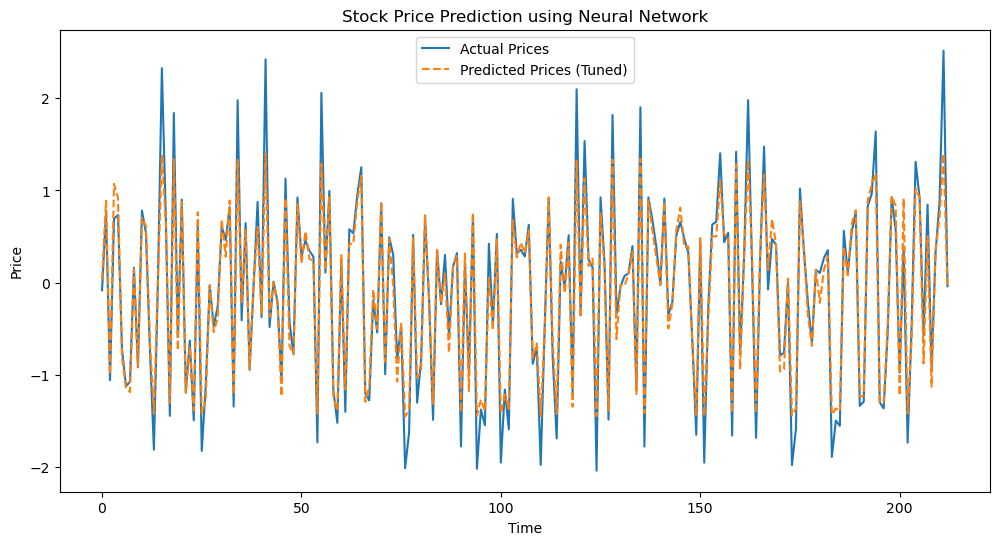

In [605]:
NN_predictions_model4 = NNmodel4.predict(X_test)

# Plot the results for the tuned NN model
plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Prices")
plt.plot(NN_predictions_model4, label="Predicted Prices (Tuned)", linestyle='--')
plt.title('Stock Price Prediction using Neural Network')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [606]:
# Calculate metrics
mse_nn4 = mean_squared_error(y_test, NN_predictions_model4)
rmse_nn4 = np.sqrt(mse_nn4)
mae_nn4 = mean_absolute_error(y_test, NN_predictions_model4)
r2_nn4 = r2_score(y_test, NN_predictions_model4)

#train metrics
y_train_pred_nn4 = NNmodel4.predict(X_train)
train_mse_nn4 = mean_squared_error(y_train, y_train_pred_nn4)
train_r2_nn4 = r2_score(y_train, y_train_pred_nn4)

#val metrics
y_val_pred_nn4 = NNmodel4.predict(X_val)
val_mse_nn4 = mean_squared_error(y_val, y_val_pred_nn4)
val_r2_nn4 = r2_score(y_val, y_val_pred_nn4)

# Output the results
print("Mean Squared Error (MSE):", mse_nn4)
print("Root Mean Squared Error (RMSE):", rmse_nn4)
print("Mean Absolute Error (MAE):", mae_nn4)
print("R-squared (R²):", r2_nn4)
print("Training:\n") #######
print("Mean Squared Error (MSE):", train_mse_nn4)
print("R-squared (R²):", train_r2_nn4)
print("Validation:\n")#######
print("Mean Squared Error (MSE):", val_mse_nn4)
print("R-squared (R²):", val_r2_nn4)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 0.06268615705278326
Root Mean Squared Error (RMSE): 0.250372037282088
Mean Absolute Error (MAE): 0.16717063546842478
R-squared (R²): 0.9403927883409093
Training:

Mean Squared Error (MSE): 0.05820811023258056
R-squared (R²): 0.9423885596987512
Validation:

Mean Squared Error (MSE): 0.05236619869728831
R-squared (R²): 0.9492011358925014


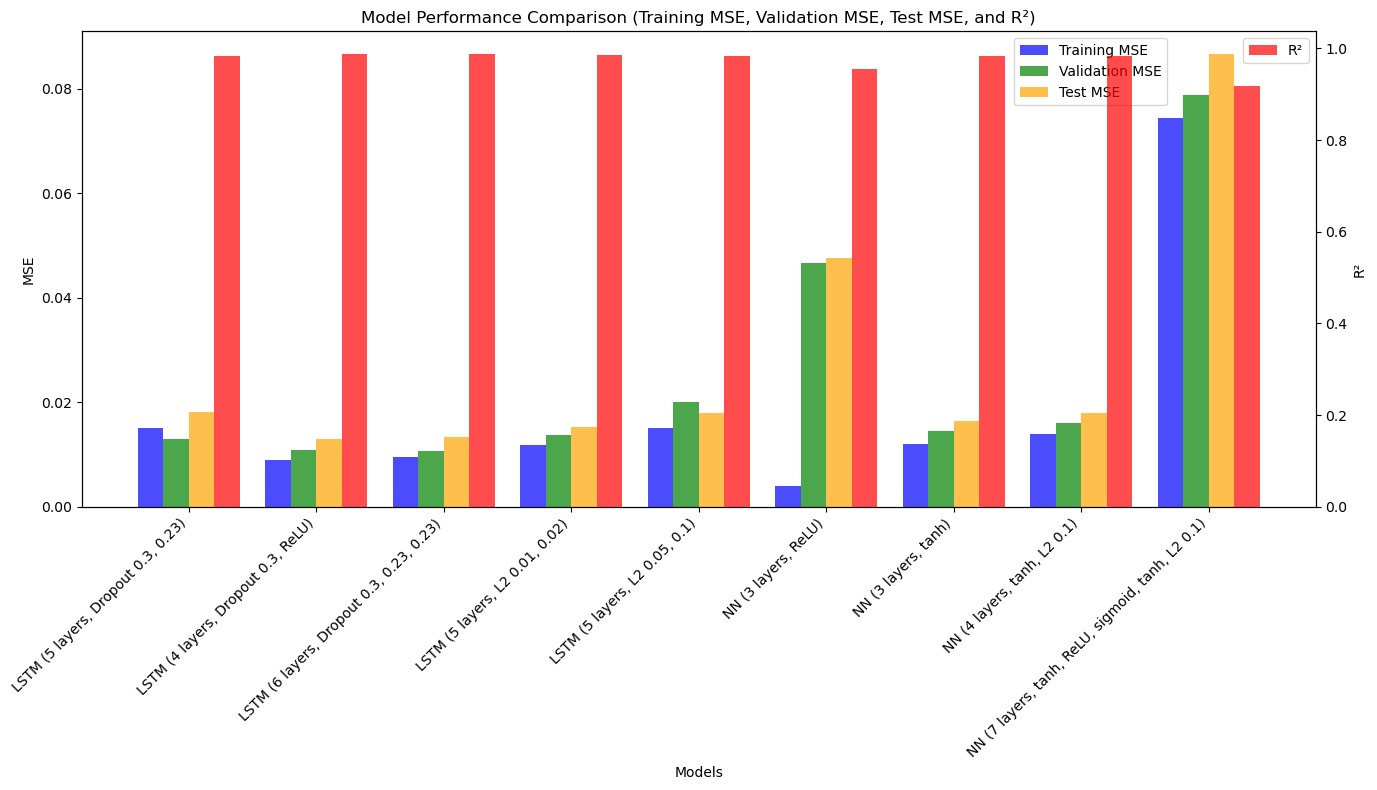

In [607]:
# Data
models = [
    "LSTM (5 layers, Dropout 0.3, 0.23)",
    "LSTM (4 layers, Dropout 0.3, ReLU)",
    "LSTM (6 layers, Dropout 0.3, 0.23, 0.23)",
    "LSTM (5 layers, L2 0.01, 0.02)",
    "LSTM (5 layers, L2 0.05, 0.1)",
    "NN (3 layers, ReLU)",
    "NN (3 layers, tanh)",
    "NN (4 layers, tanh, L2 0.1)",
    "NN (7 layers, tanh, ReLU, sigmoid, tanh, L2 0.1)"
]

training_mse = [0.0151, 0.0089, 0.0095, 0.0118, 0.0151, 0.0039, 0.0121, 0.0139, 0.0744]
validation_mse = [0.0129, 0.0108, 0.0107, 0.0138, 0.0201, 0.0467, 0.0145, 0.0161, 0.0788]
test_mse = [0.0182, 0.0129, 0.0133, 0.0152, 0.0180, 0.0477, 0.0165, 0.0179, 0.0867]
r2 = [0.9827, 0.9877, 0.9874, 0.9856, 0.9829, 0.9546, 0.9843, 0.9830, 0.9176]

# Plotting
x = np.arange(len(models))  # x-axis positions
width = 0.2  # Width of the bars

fig, ax1 = plt.subplots(figsize=(14, 8))

# Training MSE Plot
ax1.bar(x - width*1.5, training_mse, width, label='Training MSE', color='blue', alpha=0.7)

# Validation MSE Plot
ax1.bar(x - width/2, validation_mse, width, label='Validation MSE', color='green', alpha=0.7)

# Test MSE Plot
ax1.bar(x + width/2, test_mse, width, label='Test MSE', color='orange', alpha=0.7)

# R² Plot (right y-axis)
ax2 = ax1.twinx()
ax2.bar(x + width*1.5, r2, width, label='R²', color='red', alpha=0.7)

# Labels and Titles
ax1.set_xlabel('Models')
ax1.set_ylabel('MSE', color='black')
ax2.set_ylabel('R²', color='black')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
ax1.set_title('Model Performance Comparison (Training MSE, Validation MSE, Test MSE, and R²)')

# Legends
ax1.legend(loc='upper left', bbox_to_anchor=(0.75, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Adjust layout
fig.tight_layout()
plt.show()
